In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plot style for consistency
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Load the dataset
try:
    df = pd.read_csv("Prices.csv")
    print("Dataset loaded successfully!")
    print("Initial dataset shape:", df.shape)
except FileNotFoundError:
    print("Error: 'Prices.csv' file not found. Please ensure the file is in the correct directory.")
    exit()

Dataset loaded successfully!
Initial dataset shape: (851264, 7)


In [3]:
# Check for missing values
print("\nMissing Values per Column:")
missing_counts = df.isnull().sum()
print(missing_counts)


Missing Values per Column:
date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


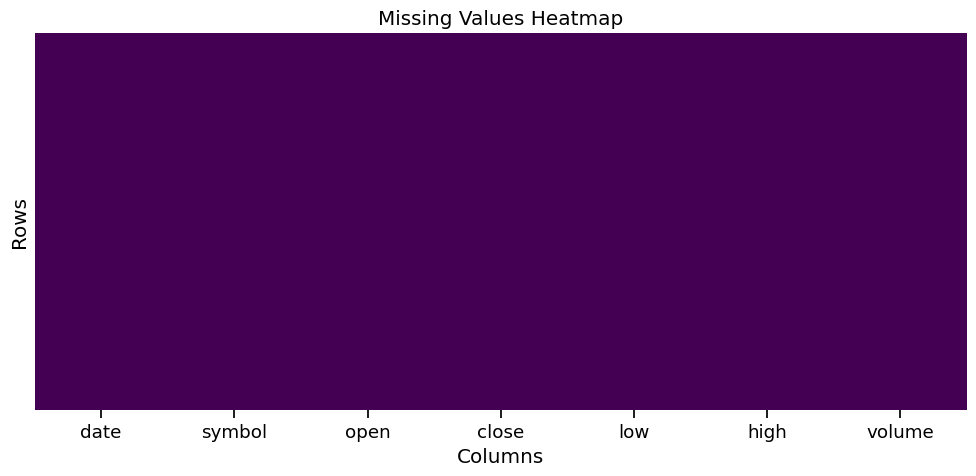

In [4]:
# Visualize missing data
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [5]:
# Handle missing values
total_missing = missing_counts.sum()
if total_missing == 0:
    print("No missing values found!")
else:
    print(f"Found {total_missing} missing values.")
    # Drop rows with missing critical columns (adjust as needed)
    critical_cols = ["date", "open", "close", "low", "high", "volume"]
    df.dropna(subset=critical_cols, inplace=True)
    print(f"Rows after dropping missing values: {df.shape[0]}")


No missing values found!


In [6]:
# Check for duplicate rows
dupes = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dupes}")
if dupes > 0:
    df.drop_duplicates(inplace=True)
    print(f"Rows after dropping duplicates: {df.shape[0]}")



Number of duplicate rows: 0


In [7]:
# Convert data types
try:
    df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y", errors="coerce")
    numeric_cols = ["open", "close", "low", "high", "volume"]
    df[numeric_cols] = df[numeric_cols].astype(float, errors="raise")
except ValueError as e:
    print(f"Error in data type conversion: {e}")
    exit()

In [8]:
# Check for invalid dates
if df["date"].isnull().any():
    print("Warning: Some dates could not be parsed and contain NaT values.")
    df.dropna(subset=["date"], inplace=True)
    print(f"Rows after dropping invalid dates: {df.shape[0]}")


In [9]:
# Validate price and volume data
invalid_checks = {
    "open": (df["open"] <= 0).sum(),
    "close": (df["close"] <= 0).sum(),
    "low": (df["low"] <= 0).sum(),
    "high": (df["high"] <= 0).sum(),
    "volume": (df["volume"] < 0).sum()
}

print("\nInvalid Data Checks:")
for col, count in invalid_checks.items():
    print(f"Invalid {col} values (<=0 for prices, <0 for volume): {count}")



Invalid Data Checks:
Invalid open values (<=0 for prices, <0 for volume): 0
Invalid close values (<=0 for prices, <0 for volume): 0
Invalid low values (<=0 for prices, <0 for volume): 0
Invalid high values (<=0 for prices, <0 for volume): 0
Invalid volume values (<=0 for prices, <0 for volume): 0


In [10]:
# Remove rows with invalid prices or volumes
initial_rows = df.shape[0]
df = df[(df["open"] > 0) & (df["close"] > 0) & (df["low"] > 0) & (df["high"] > 0) & (df["volume"] >= 0)]
print(f"Rows after removing invalid data: {df.shape[0]} (Removed {initial_rows - df.shape[0]} rows)")


Rows after removing invalid data: 851264 (Removed 0 rows)


In [11]:
# Additional validation: Ensure low <= close <= high and low <= open <= high
invalid_price_logic = ((df["close"] < df["low"]) | (df["close"] > df["high"]) | 
                      (df["open"] < df["low"]) | (df["open"] > df["high"])).sum()
print(f"Rows with illogical price relationships (e.g., close < low or close > high): {invalid_price_logic}")
if invalid_price_logic > 0:
    df = df[~((df["close"] < df["low"]) | (df["close"] > df["high"]) | 
              (df["open"] < df["low"]) | (df["open"] > df["high"]))]
    print(f"Rows after removing illogical price data: {df.shape[0]}")


Rows with illogical price relationships (e.g., close < low or close > high): 0


In [12]:
# Outlier detection using IQR for prices
price_cols = ["open", "close", "low", "high"]
outliers = pd.DataFrame()
for col in price_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers = pd.concat([outliers, col_outliers])
print(f"\nPotential outliers in price columns: {outliers.shape[0]} rows")
if outliers.shape[0] > 0:
    print("Note: Outliers detected. Consider reviewing or removing them based on domain knowledge.")



Potential outliers in price columns: 206319 rows
Note: Outliers detected. Consider reviewing or removing them based on domain knowledge.


In [13]:
# Create new features
df["price_range"] = df["high"] - df["low"]
df["daily_return"] = (df["close"] - df["open"]) / df["open"]
df["avg_price"] = (df["high"] + df["low"] + df["close"]) / 3

# Summary statistics for new features
print("\nNew Features Summary Statistics:")
print(df[["price_range", "daily_return", "avg_price"]].describe())


New Features Summary Statistics:
         price_range   daily_return      avg_price
count  851264.000000  851264.000000  851264.000000
mean        1.303207       0.000420      64.996067
std         1.829946       0.014783      75.187033
min         0.000000      -0.255378       1.680000
25%         0.520001      -0.007021      31.286667
50%         0.860000       0.000461      48.463333
75%         1.440003       0.007948      75.126666
max        96.440064       0.449889    1569.113322


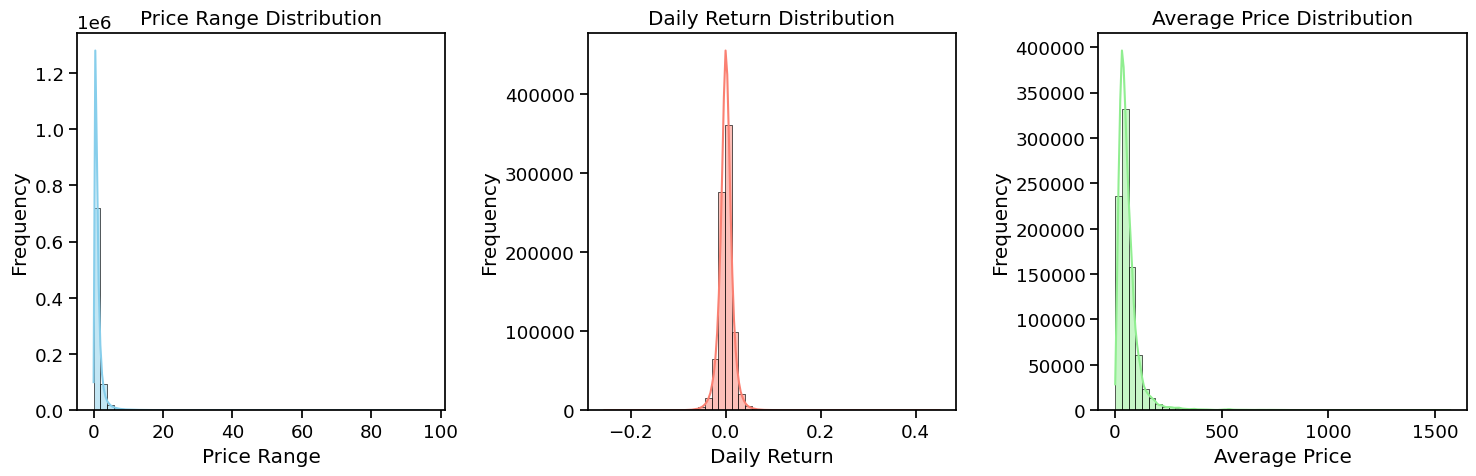

In [14]:
# Visualize distributions of new features
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df["price_range"], bins=50, kde=True, color="skyblue")
plt.title("Price Range Distribution")
plt.xlabel("Price Range")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
sns.histplot(df["daily_return"], bins=50, kde=True, color="salmon")
plt.title("Daily Return Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
sns.histplot(df["avg_price"], bins=50, kde=True, color="lightgreen")
plt.title("Average Price Distribution")
plt.xlabel("Average Price")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [15]:
# Save the cleaned dataset
df.to_csv("Prices_Cleaned.csv", index=False)
print("Cleaned dataset saved to 'Prices_Cleaned.csv'.")

Cleaned dataset saved to 'Prices_Cleaned.csv'.
